In [1]:

# coding: utf-8

# In[14]:

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

class TwoPathConv(nn.Module):
    def __init__(self):
        super(TwoPathConv, self).__init__()
        self.local_conv1 = nn.Conv2d(3, 64, 7)
        self.local_conv2 = nn.Conv2d(64, 64, 3)
        self.local_conv3 = nn.Conv2d(3, 160, 13)
        self.total_conv = nn.Conv2d(224, 3, 21)

    def forward(self, x):
        under_x = F.relu(self.local_conv3(x))
        x = self.local_conv1(x)
        x = F.max_pool2d(F.relu(x), 4, stride = 1)
        x = self.local_conv2(x)
        x = F.max_pool2d(F.relu(x), 2, stride = 1)
        x = torch.cat((x, under_x), 1)
        x = self.total_conv(x)
        x = x.view(-1,3)
        return x

    
import h5py
#challenge_f = h5py.File('Challenge.h5', 'r') #load challenge data
train_f = h5py.File('unet/Unet-training.h5', 'r')
SAMPLE = [ "LG/0001", "LG/0002", "LG/0004", "LG/0006", "LG/0008", "LG/0011",
          "LG/0012", "LG/0013", "LG/0014", "LG/0015", "HG/0001", "HG/0002",
          "HG/0003", "HG/0004", "HG/0005", "HG/0006", "HG/0007", "HG/0008",
          "HG/0009", "HG/0010", "HG/0011", "HG/0012", "HG/0013", "HG/0014",
          "HG/0015", "HG/0022", "HG/0024", "HG/0025", "HG/0026", "HG/0027",]
'''
train_f = h5py.File('Challenge.h5', 'r')
SAMPLE = [ "HG/0301", "HG/0302",
          "HG/0303", "HG/0304", "HG/0305", "HG/0306", "HG/0307", "HG/0308",
          "HG/0309", "HG/0310", ]
'''
#for i in enumerate(SAMPLE):
#    index, case = i
#    case1 = case[:2]
#    case2 = case[3:]
#    print(challenge_f[case1][case2].shape)
    
"""def create_test_batch(img = 0, x = 16, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:4,:,:,z]
    for y in range(16, Y - 16):
        content=img1[:, x-16:x+17, y-16:y+17]
        content[3, :,:]=0
        batch.append(content)
    batch = torch.from_numpy(np.array(batch))
    return batch
"""
def create_test_batch(img = 0, x = 16, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:4,:,:,z]
    for y in range(16, Y - 16):
        content=img1[0:3, x-16:x+17, y-16:y+17]
        batch.append(content)
    batch = torch.from_numpy(np.array(batch))
    return batch


def create_test_batch_cas(img = 0, x = 32, z= 0):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    batch = []
    _, X, Y, Z = train_f[case1][case2].shape
    img1 = train_f[case1][case2][:,:,:,z]
    img1 = np.pad(img1, pad_width = ((0,0), (32,32), (32,32)), mode = 'constant')
    for y in range(32, Y + 32):
        batch.append(img1[:, x-32:x+33, y-32:y+33])
    batch = torch.from_numpy(np.array(batch))
    return batch

# In[ ]:

In [2]:
import time
import numpy as np
from torch.autograd import Variable
net = TwoPathConv()
#net = LocalPathConv()
#net = InputCasNet()
net.load_state_dict(torch.load('2ch/HG3ch_p1_3.txt'))
#net.load_state_dict(torch.load('local_path_cnn/phase1_param_l1_1.txt'))
#net.load_state_dict(torch.load('phase1_input_cas_net.txt'))
net.cuda(1)

TwoPathConv (
  (local_conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
  (local_conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (local_conv3): Conv2d(3, 160, kernel_size=(13, 13), stride=(1, 1))
  (total_conv): Conv2d(224, 3, kernel_size=(21, 21), stride=(1, 1))
)

In [10]:
prev_time = time.clock()
#print(matrix_pred)
s = 0
#matrix_pred = {}
pred = {}
matrix_pred ={}

for img in range(17, 18):
    case = SAMPLE[img]
    case1 = case[:2]
    case2 = case[3:]
    #_, X, Y, Z = challenge_f[case1][case2].shape
    _, X, Y, Z = train_f[case1][case2].shape
    print(X, Y, Z)
    matrix_pred[img] = []
    for x in range(16, X - 16):
    #for x in range(32, X + 32):
        pred[(img,x)] = []
        for z in range(100,101):
            s += 1
            X_batch = create_test_batch(img = img, x = x, z = z)
            #X_batch = create_test_batch_cas(img = img, x = x, z = z)
            X_batch = Variable(X_batch.cuda(1))
            y_pred = net.forward(X_batch)
            y_pred = y_pred.data.cpu().numpy()
            if (s%10 == 0):
                print ('Ongoing ...' ,(img, x, z))
                print ('time used %.3f' % (time.clock()-prev_time))
            pred[(img,x)].append(y_pred.argmax(axis = 1)) 
        matrix_pred[img].append(pred[(img,x)])



160 216 176
Ongoing ... (17, 25, 100)
time used 0.484
Ongoing ... (17, 35, 100)
time used 0.858
Ongoing ... (17, 45, 100)
time used 1.220
Ongoing ... (17, 55, 100)
time used 1.558
Ongoing ... (17, 65, 100)
time used 1.896
Ongoing ... (17, 75, 100)
time used 2.234
Ongoing ... (17, 85, 100)
time used 2.574
Ongoing ... (17, 95, 100)
time used 2.912
Ongoing ... (17, 105, 100)
time used 3.250
Ongoing ... (17, 115, 100)
time used 3.587
Ongoing ... (17, 125, 100)
time used 3.925
Ongoing ... (17, 135, 100)
time used 4.263


(128, 1, 184)


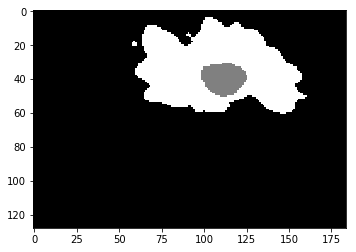

In [11]:
img = 17
matrix_pred[img] = np.array(matrix_pred[img])
print(matrix_pred[img].shape)
plt.imshow(matrix_pred[img][:,0,:], cmap='gray')
plt.show()

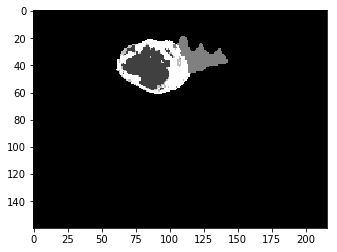

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  3.  3.  3.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.  4.  4.  4.  4.  4.  4.  4.  2.  2.  2.  2.  2.  2.  2.  2.  0.
  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [8]:
case = SAMPLE[10] 
case1 = case[:2] 
case2 = case[3:] 
_, X, Y, Z = train_f[case1][case2].shape 
for i in range(4,5): 
    plt.imshow(train_f[case1][case2][i,:,:,80], cmap='gray') 
    plt.show()
print(train_f[case1][case2][i,40,:,100])

In [ ]:
#cas-net test

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import h5py
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import torch.nn.init as ini
import multiprocessing
from multiprocessing import Queue
import random
from random import shuffle
import pickle

class InputCasNet(nn.Module):
    def __init__(self):
        super(InputCasNet, self).__init__()
        self.first_upper_layer1=nn.Sequential(
            nn.Conv2d(4,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.first_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.first_under_layer1=nn.Sequential(
            nn.Conv2d(4,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        
        self.first_final_layer=nn.Conv2d(224,5,21)
        
        self.second_upper_layer1=nn.Sequential(
            nn.Conv2d(9,64,7),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((4,4),stride = 1)
        )
        self.second_upper_layer2=nn.Sequential(
            nn.Conv2d(64,64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,2),stride = 1)
        )
        self.second_under_layer1=self.under_layer1 = nn.Sequential(
            nn.Conv2d(9,160,13),
            nn.BatchNorm2d(160),
            nn.ReLU()
        )
        self.second_final_layer = nn.Conv2d(224,5,21)
    
    def forward(self, x1):
        upper_x=self.first_upper_layer2(self.first_upper_layer1(x1))
        under_x=self.first_under_layer1(x1)
        x=torch.cat((upper_x, under_x), 1)
        x=self.first_final_layer(x)
        x2=x1[:, :, 16:48+1, 16:48+1]*1.0
        x2=torch.cat((x, x2), 1)
        upper_x2=self.second_upper_layer2(self.second_upper_layer1(x2))
        under_x2=self.second_under_layer1(x2)
        x3=torch.cat((upper_x2, under_x2), 1)
        x3=self.second_final_layer(x3)
        return x3

cas_net=InputCasNet()
cas_net.load_state_dict(torch.load('phase1_input_cas_net.txt'))
cas_net.cuda(0)